# Plot the Init decalib, GT, Pred, Keypoints and Feature Embeddings  

In [ ]:
import sys
sys.path.append('/workspace/')

import os
import numpy as np
import torch
from torch.utils.data import DataLoader

#from data.kitti_data import KittiDataset
#from data.nuscenes_data import NuscenesDataset

from models import HRegNet, Model_V2, Model_V6
from models.utils import calc_error_np, set_seed

import argparse
import datetime
from tqdm import tqdm

#MAN Dataset
from config import Config
import dataset

from losses import transformation_loss
from metrics.calibeval import CalibEval, MultiLayerCalibEval
from dataset.data_loader import load_dataset


def parse_args(args_list=None):
    parser = argparse.ArgumentParser(description='HRegNet')

    parser.add_argument('--seed', type=int, default=1)
    parser.add_argument('--gpu', type=str, default='0')
    parser.add_argument('--root', type=str, default='')
    parser.add_argument('--npoints', type=int, default=16384)
    parser.add_argument('--epochs', type=int, default=100)
    parser.add_argument('--batch_size', type=int, default=2)
    parser.add_argument('--dataset', type=str, default='man')
    parser.add_argument('--use_fps', action='store_true')
    parser.add_argument('--data_list', type=str, default='')
    parser.add_argument('--use_weights', action='store_true')
    parser.add_argument('--pretrain_weights', type=str, default='')
    parser.add_argument('--voxel_size', type=float, default=0.3)
    parser.add_argument('--save_dir',type=str, default='')
    parser.add_argument('--augment', type=float, default=0.0)
    parser.add_argument('--freeze_detector', action='store_true')
    parser.add_argument('--freeze_feats', action='store_true')
    
    return parser.parse_args(args_list)


args = parse_args(['--use_fps', '--use_weights', '--freeze_detector', 
                   '--pretrain_weights', '/workspace/ckpt/Adaption1_Hregnet_mi/best_val.pth'])

model_name = HRegNet

"""
 Change the above model_name and --pretrain_weights 
    Name    - model_name - pretrain_weights
    HRegNet - HRegNet    - /workspace/ckpt/Baseline_Hregnet/best_val_loss.pth
    A1      - Model_V2   - /workspace/ckpt/Adaption1_Hregnet_mi/best_val.pth
    A2      - Model_V6   - /workspace/ckpt/Adaption2_ptv3/best_val_RRE.pth """



'\n Change the --model and --pretrain_weights \n    Name    - model     - pretrain_weights\n    HRegNet - HRegNet   - /workspace/ckpt/Baseline_Hregnet/best_val_loss.pth\n    A1      - Model_V2  - /workspace/ckpt/Adaption1_Hregnet_mi/best_val.pth\n    A2      - Model_V6  - /workspace/ckpt/man_ckpt_Phil_T29_g_Full_Registration/best_val_RRE.pth '

# Load config, model and dataset

In [ ]:
config = Config(args)
test_dataset = load_dataset(config=config, split='test')

# Initialize the Dataloader
test_loader = DataLoader(dataset=test_dataset, batch_size=args.batch_size, shuffle=False, num_workers=4)

#Initiailze the model
net = model_name(args).cuda()

#config.dataset_config.model = net.__class__.__name__


# Load the weights
checkpoint = torch.load(args.pretrain_weights)
if "net_state_dict" in checkpoint:
    net.load_state_dict(checkpoint["net_state_dict"],strict=False) 
else:
    raise KeyError("Key 'net_state_dict' not found in checkpoint file")

# Set the model to eval() mode
net.eval()

with torch.no_grad():
    
    for i, data in enumerate(test_loader):
        
        #start_t = datetime.datetime.now()
        src_points = data['uncalibed_pcd'].contiguous().cuda()
        dst_points = data['pcd_left'].contiguous().cuda()
        igt = data['igt'].contiguous().cuda()

        ret_dict = net(src_points, dst_points)
        break


# Plot Keypoints

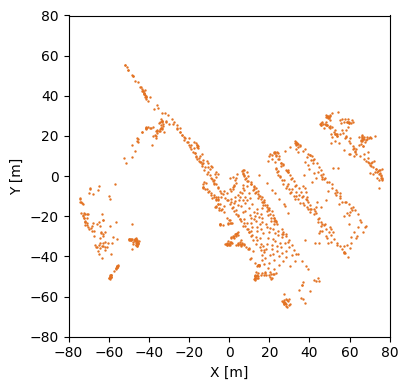

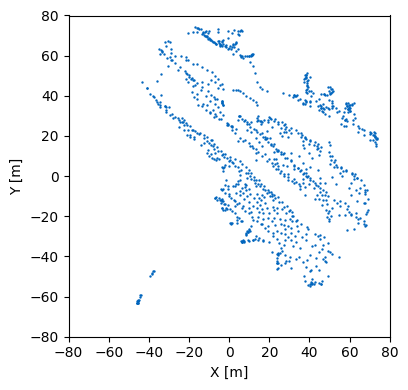

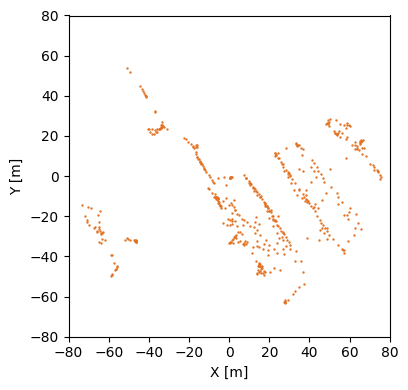

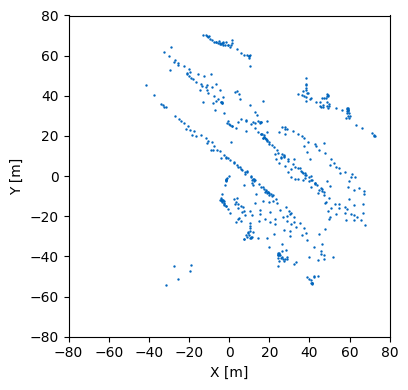

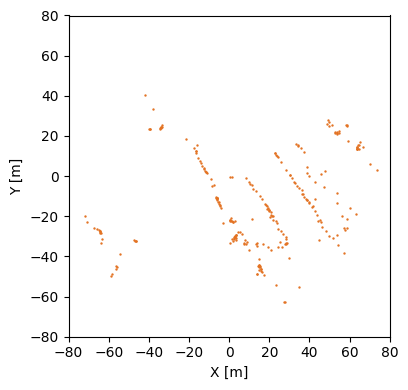

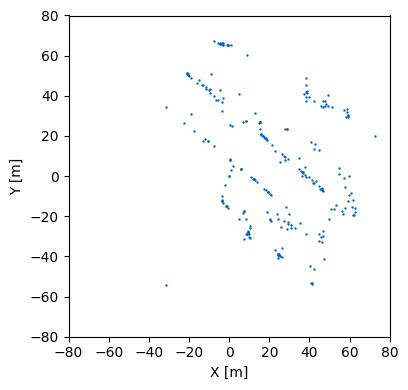

In [ ]:
import matplotlib.pyplot as plt

# Process only the first sample
dst_cloud = dst_points[0].cpu().numpy()       # Calibrated left point cloud
calib_right = data['pcd_right'][0].cpu().numpy()  # Calibrated right point cloud
src_cloud = src_points[0].cpu().numpy()         # Decalibrated right point cloud

# Keypoints from three layers for src and dst (each shape: N×3)
src_xyz1 = ret_dict['src_feats']['xyz_1'][0].cpu().numpy()
src_xyz2 = ret_dict['src_feats']['xyz_2'][0].cpu().numpy()
src_xyz3 = ret_dict['src_feats']['xyz_3'][0].cpu().numpy()

dst_xyz1 = ret_dict['dst_feats']['xyz_1'][0].cpu().numpy()
dst_xyz2 = ret_dict['dst_feats']['xyz_2'][0].cpu().numpy()
dst_xyz3 = ret_dict['dst_feats']['xyz_3'][0].cpu().numpy()

def plot_keypoints_individual(src_xyz1, dst_xyz1, src_xyz2, dst_xyz2, src_xyz3, dst_xyz3):

    s = 0.5
    left_color = "#0065BD"
    right_color = "#E37222"

    # Prepare a list for each subplot with its data, title, and color.
    plots = [
        {"data": src_xyz1, "title": "Layer 1 Source", "color": right_color},
        {"data": dst_xyz1, "title": "Layer 1 Target", "color": left_color},
        {"data": src_xyz2, "title": "Layer 2 Source", "color": right_color},
        {"data": dst_xyz2, "title": "Layer 2 Target", "color": left_color},
        {"data": src_xyz3, "title": "Layer 3 Source", "color": right_color},
        {"data": dst_xyz3, "title": "Layer 3 Target", "color": left_color},
    ]
    
    for plot in plots:
        plt.figure(figsize=(5, 4))
        plt.scatter(plot["data"][:, 0], plot["data"][:, 1], s=s, color=plot["color"])
        #plt.title(plot["title"], fontsize=10)
        plt.xlabel('X [m]', fontsize=10)
        plt.ylabel('Y [m]', fontsize=10)
        plt.xlim(-80, 80)
        plt.ylim(-80, 80)
        plt.xticks([-80, -60, -40, -20, 0, 20, 40, 60, 80], fontsize=10)
        plt.yticks(fontsize=10)
        plt.gca().set_aspect('equal', adjustable='box')
        plt.tight_layout()
        filename = "keypoints_" + plot["title"].replace(" ", "_").lower() + ".svg"
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        plt.show()

plot_keypoints_individual(src_xyz1, dst_xyz1, src_xyz2, dst_xyz2, src_xyz3, dst_xyz3)

# Plot Feature Embeddings

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def features_to_rgb_image(points, features, grid_resolution=256, xlim=(-80, 80), ylim=(-80, 80)):
    """
    Converts point features into an RGB image based on their (x,y) positions.
    
    points: (N,2) array of (x,y) positions.
    features: (N, C) array of feature vectors.
    grid_resolution: resolution of the output image (grid_resolution x grid_resolution).
    xlim, ylim: spatial limits.
    
    Returns:
        img: (grid_resolution, grid_resolution, 3) RGB image.
             Grid cells with no data are set to white.
    """
    # Ensure features has shape (N, C). If 1D, reshape to (N,1) then replicate to 3 channels.
    if features.ndim == 1:
        features = features.reshape(-1, 1)
    if features.shape[1] == 1:
        features = np.tile(features, (1, 3))
    
    # Reduce feature dimension to 3 using PCA.
    pca = PCA(n_components=3)
    feat_reduced = pca.fit_transform(features)  # (N, 3)
    
    # Normalize features to [0,1]
    feat_min = feat_reduced.min(axis=0)
    feat_max = feat_reduced.max(axis=0)
    feat_norm = (feat_reduced - feat_min) / (feat_max - feat_min + 1e-8)
    
    # Initialize an empty image and weight matrix.
    img = np.zeros((grid_resolution, grid_resolution, 3), dtype=np.float32)
    weight = np.zeros((grid_resolution, grid_resolution), dtype=np.float32)
    
    # Map points to grid indices.
    x_range = xlim[1] - xlim[0]
    y_range = ylim[1] - ylim[0]
    grid_x = ((points[:, 0] - xlim[0]) / x_range * (grid_resolution - 1)).astype(int)
    grid_y = ((points[:, 1] - ylim[0]) / y_range * (grid_resolution - 1)).astype(int)
    
    # Clamp indices to valid range.
    grid_x = np.clip(grid_x, 0, grid_resolution - 1)
    grid_y = np.clip(grid_y, 0, grid_resolution - 1)
    
    # Accumulate features onto the grid.
    for i in range(points.shape[0]):
        gx = grid_x[i]
        gy = grid_y[i]
        img[gy, gx, :] += feat_norm[i]
        weight[gy, gx] += 1.0
    
    # Avoid division by zero and average overlapping points.
    mask = (weight == 0)
    weight[mask] = 1.0
    img = img / weight[:, :, None]
    img[mask, :] = 1.0  # cells with no points set to white.
    
    return np.clip(img, 0, 1)


In [ ]:

def plot_feature_subplot(ax, points, features, title):
    """
    Plots a feature map on a given axis.
    """
    # Use the first two columns (x,y) from points.
    points_2d = points[:, :2]
    img = features_to_rgb_image(points_2d, features, grid_resolution=128, xlim=(-80, 80), ylim=(-80, 80))
    # Set origin='lower' so that the y-axis orientation matches scatter plots.
    ax.imshow(img, extent=(-80, 80, -80, 80), origin='lower')
    #ax.set_title(title, fontsize=10)
    ax.set_xlabel('X [m]', fontsize=10)
    ax.set_ylabel('Y [m]', fontsize=10)
    ax.set_xlim(-80, 80)
    ax.set_ylim(-80, 80)
    ax.set_xticks(np.linspace(-80, 80, 9))
    ax.set_aspect('equal', adjustable='box')

def plot_feature_individual(points, features, title):
    """
    Creates a new figure, plots the feature map using plot_feature_subplot,
    and saves the figure with a filename derived from the title.
    """
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(figsize=(4, 4))
    plot_feature_subplot(ax, points, features, title)
    plt.tight_layout()
    filename = "A1_" + title.replace(" ", "_").lower() + ".svg"
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()




In [ ]:
# Set up data for feature maps.
# For keypoint features, we use the keypoint positions:
left_points1  = dst_xyz1    # calibrated target keypoints (layer1)
left_points2  = dst_xyz2    # layer2
left_points3  = dst_xyz3    # layer3

right_points1 = src_xyz1    # decalibrated source keypoints (layer1)
right_points2 = src_xyz2    # layer2
right_points3 = src_xyz3    # layer3

# For registration features, use the registration keypoints.
coarse_reg_points = ret_dict['src_xyz_corres_3'][0].cpu().numpy()
fine_reg1_points  = ret_dict['src_xyz_corres_2'][0].cpu().numpy()
fine_reg2_points  = ret_dict['src_xyz_corres_1'][0].cpu().numpy()

# For descriptors, assume (C, N)
left_feat1  = ret_dict['dst_feats']['desc_1'][0].cpu().numpy().T  # calibrated descriptor layer1
left_feat2  = ret_dict['dst_feats']['desc_2'][0].cpu().numpy().T  # layer2
left_feat3  = ret_dict['dst_feats']['desc_3'][0].cpu().numpy().T  # layer3

right_feat1 = ret_dict['src_feats']['desc_1'][0].cpu().numpy().T  # decalibrated descriptor layer1
right_feat2 = ret_dict['src_feats']['desc_2'][0].cpu().numpy().T  # layer2
right_feat3 = ret_dict['src_feats']['desc_3'][0].cpu().numpy().T  # layer3

# For registration features, use the weights (reshape to (N,1)).
coarse_reg_feat = ret_dict['src_dst_weights_3'][0].cpu().numpy().reshape(-1, 1)
fine_reg1_feat  = ret_dict['src_dst_weights_2'][0].cpu().numpy().reshape(-1, 1)
fine_reg2_feat  = ret_dict['src_dst_weights_1'][0].cpu().numpy().reshape(-1, 1)

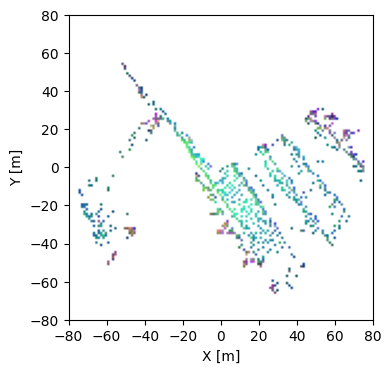

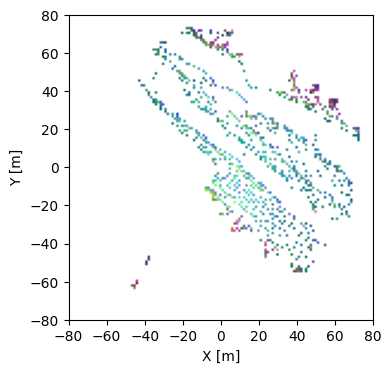

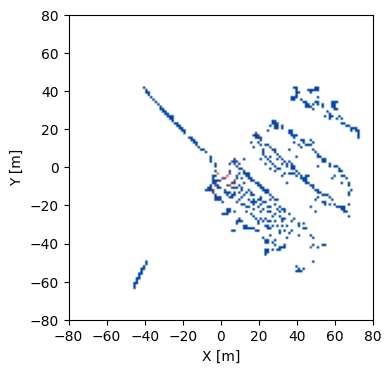

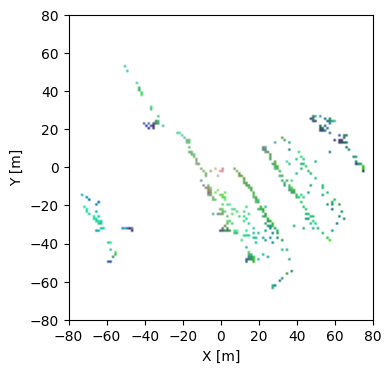

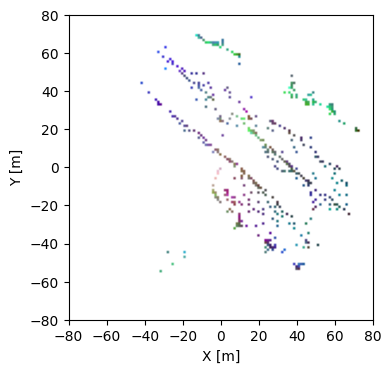

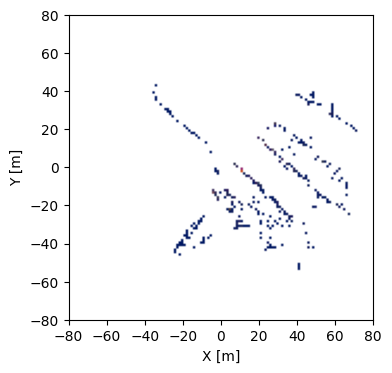

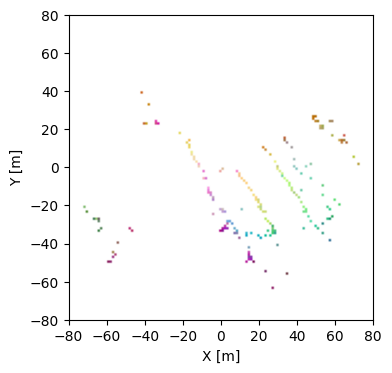

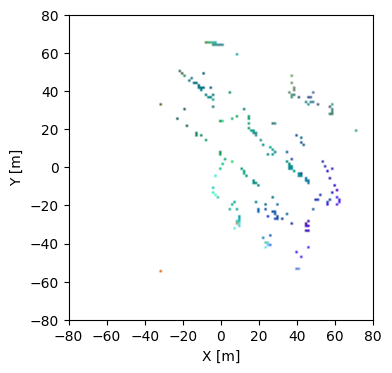

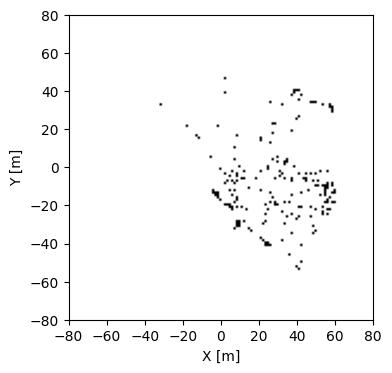

In [ ]:
# plot each feature map individually:
plot_feature_individual(right_points1, right_feat1, "Source Keypoint Feature Layer 1")
plot_feature_individual(left_points1, left_feat1, "Target Keypoint Feature Layer 1")
plot_feature_individual(fine_reg2_points, fine_reg2_feat, "Correspondences Fine Reg 1")

plot_feature_individual(right_points2, right_feat2, "Source Keypoint Feature Layer 2")
plot_feature_individual(left_points2, left_feat2, "Target Keypoint Feature Layer 2")
plot_feature_individual(fine_reg1_points, fine_reg1_feat, "Correspondences Fine Reg 2")

plot_feature_individual(right_points3, right_feat3, "Source Keypoint Feature Layer 3")
plot_feature_individual(left_points3, left_feat3, "Target Keypoint Feature Layer 3")
plot_feature_individual(coarse_reg_points, coarse_reg_feat, "Correspondences Coarse Reg")

# Plot GT, Initial decalib and Predicted Calibration

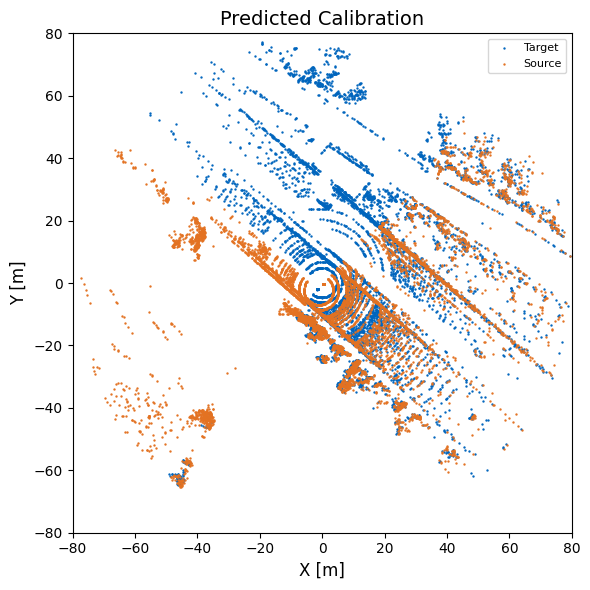

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

left_color = "#0065BD"
right_color = "#E37222"

# Extracting 0th sample's rotation and translation
R = ret_dict['rotation'][2][0].cpu().numpy()   # Shape: (3,3)
t = ret_dict['translation'][2][0].cpu().numpy()  # Shape: (3,)

# Build the 4x4 homogeneous transformation matrix.
T = np.eye(4)
T[:3, :3] = R
T[:3, 3] = t

# Get the source (decalibrated) point cloud for sample 0.
src_cloud = src_points[0].cpu().numpy()   # Shape: (N,3)

# Convert src_cloud to homogeneous coordinates.
N = src_cloud.shape[0]
src_cloud_h = np.hstack([src_cloud, np.ones((N, 1))])  # Shape: (N,4)

# Apply the transformation: calibrated_src = T * src_cloud_h
calibrated_src = (T @ src_cloud_h.T).T  # Shape: (N,4)
calibrated_src = calibrated_src[:, :3]   # Back to (N,3)

# Get the target (calibrated) point cloud for sample 0.
dst_cloud = dst_points[0].cpu().numpy()  # Shape: (N,3)

# Plot both clouds in one figure with the same color and marker style.
plt.figure(figsize=(6, 6))
s = 0.5
plot_color = 'blue'

plt.scatter(dst_cloud[:, 0], dst_cloud[:, 1], s=s, color=left_color, label='Target')
plt.scatter(calibrated_src[:, 0], calibrated_src[:, 1], s=s, color=right_color, label='Source')

plt.title('Predicted Calibration',fontsize=14)
plt.xlabel('X [m]',fontsize=12)
plt.ylabel('Y [m]',fontsize=12)
plt.xlim(-80, 80)
plt.ylim(-80, 80)
plt.legend(fontsize=8)
plt.gca().set_aspect('equal', adjustable='box')
plt.tight_layout()
plt.savefig("output.svg", dpi=300, bbox_inches='tight')
plt.show()


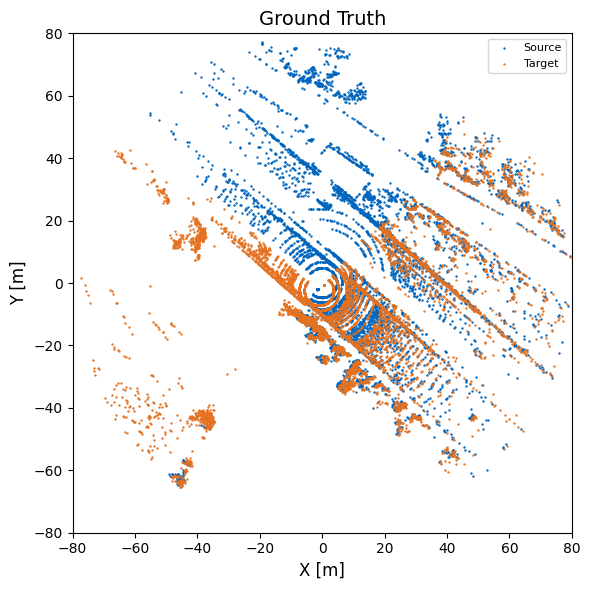

In [ ]:
# Create a 4x2 grid: 4 rows, 2 columns
plt.figure(figsize=(6, 6))

# ---------------- First Row: Input Cloud Overlays -----------------
# Subplot (0,0): Overlay of calibrated left and calibrated right clouds
plt.scatter(dst_cloud[:, 0], dst_cloud[:, 1], s=s, color=left_color, label='Source')
plt.scatter(calib_right[:, 0], calib_right[:, 1], s=s, color=right_color, label='Target')
plt.title('Ground Truth',fontsize=14)
plt.xlabel('X [m]',fontsize=12)
plt.ylabel('Y [m]',fontsize=12)
plt.xlim(-80, 80)
plt.ylim(-80, 80)
plt.legend(fontsize=8)
plt.gca().set_aspect('equal', adjustable='box')
plt.tight_layout()
plt.savefig("ground_truth.svg", dpi=300,bbox_inches='tight')
plt.show()

# # Subplot (0,1): Calibrated left and decalibrated right clouds
# axes[0, 1].scatter(dst_cloud[:, 0], dst_cloud[:, 1], s=s, color=left_color, label='Left Calibrated')
# axes[0, 1].scatter(src_cloud[:, 0], src_cloud[:, 1], s=s, color=right_color, label='Right Decalibrated')
# axes[0, 1].set_title('Initial Decalibration')
# axes[0, 1].legend()

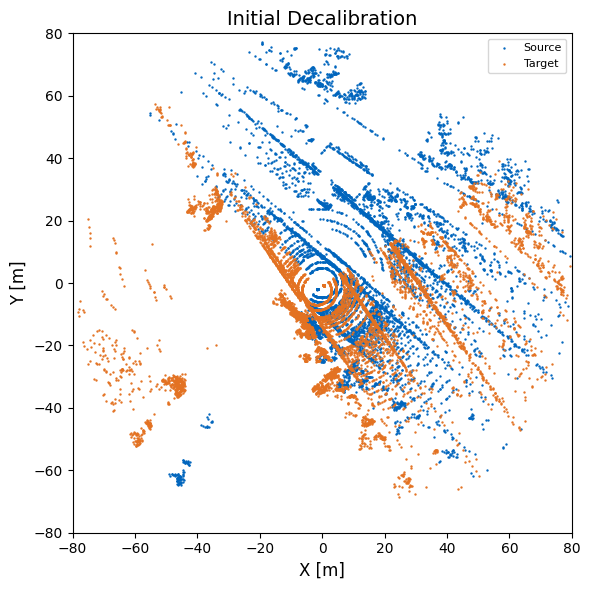

In [ ]:
# Create a 4x2 grid: 4 rows, 2 columns
plt.figure(figsize=(6, 6))

# ---------------- First Row: Input Cloud Overlays -----------------
# Subplot (0,0): Overlay of calibrated left and calibrated right clouds
plt.scatter(dst_cloud[:, 0], dst_cloud[:, 1], s=s, color=left_color, label='Source')
plt.scatter(src_cloud[:, 0], src_cloud[:, 1], s=s, color=right_color, label='Target')
plt.title('Initial Decalibration', fontsize=14)
plt.xlabel('X [m]',fontsize=12)
plt.ylabel('Y [m]',fontsize=12)
plt.xlim(-80, 80)
plt.ylim(-80, 80)
plt.legend(fontsize=8)
plt.gca().set_aspect('equal', adjustable='box')
plt.tight_layout()
plt.savefig("intial_decalib.svg", dpi=300,bbox_inches='tight')
plt.show()